In [1]:
#importar librerias importantes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import shap

print(np.__version__)


1.19.1


In [2]:
#Lectura de Datos y presentación

datos=pd.read_excel('Base de datos 2.0.xlsx', header=0, error_bad_lines=False)
datos.head()

,Estraus,Comuna,Comercio,Educación,Habitación,Industria (1),Servicios (2),Otros (3),Sin Considerar (3),Total,...,min dist metro,Porcentaje proposito trabajo,porcentaje proposito estudio,porcentaje proposito volver a la casa,porcentaje ir de compras,porcentaje modo privado,porcentaje modo publico,porcentaje no motorizado,Área total (m2),sector
0,1,Independencia,12650,6333,78152,30140,8368,7563,40252,183458,...,3.041252,14.4932,8.9110,48.1465,8.4019,27.6373,23.7660,40.0923,4.678599e+05,norte
1,2,Independencia,39228,37662,321692,30722,19166,23144,33313,504927,...,1.609982,18.3619,8.5748,47.6031,13.9849,20.6951,30.0959,45.9323,1.134592e+06,norte
2,3,Independencia,46808,8041,213874,66033,12047,10053,35719,392575,...,2.549236,15.2141,5.9068,55.9761,8.4050,25.3639,11.8234,60.9220,9.133002e+05,norte
3,4,Independencia,32304,10895,247644,24324,14220,12453,47382,389222,...,1.620016,21.5194,8.7828,44.8588,16.4969,23.7714,23.5462,48.6555,7.513172e+05,norte
4,5,Independencia,11346,4685,59839,53861,6338,2742,30640,169451,...,3.120056,13.8301,0.0000,78.9652,4.8030,12.0075,21.1816,57.0884,4.106979e+05,norte


In [3]:
#Transformación Variables Categóricas
datoscat= datos[['sector']]
datoscat=pd.get_dummies(datoscat, columns = ['sector'], drop_first = True)
datoscat.head(10)

,sector_norte,sector_oriente,sector_poniente,sector_sur,sector_sur-oriente
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,1,0,0,0,0
7,1,0,0,0,0
8,1,0,0,0,0
9,1,0,0,0,0


In [4]:
#Estandarizacion Variables continuas
datoscont =datos[['Comercio','Educación','Habitación','Industria (1)','Servicios (2)','Otros (3)',
                  'Sin Considerar (3)','Min dist hosp (km)','Min dist esc',
                 'Min dist autopista','min dist cc','min dist metro','Porcentaje proposito trabajo',
                 'porcentaje proposito estudio','porcentaje ir de compras','porcentaje modo privado',
                  'porcentaje modo publico','porcentaje no motorizado','Área total (m2)']]
scaler=preprocessing.StandardScaler()
datos_est=scaler.fit_transform(datoscont)
datos_cont_est=pd.DataFrame({'Comercio':datos_est[:,0],'Educación':datos_est[:,1],'Habitación':datos_est[:,2],'Industria':datos_est[:,3],
                  'Servicios':datos_est[:,4],'Otros':datos_est[:,5],'Sin Considerar':datos_est[:,6],
                  'Dist_Hosp':datos_est[:,7],'Dist_Esc':datos_est[:,8],'Dist_Autopista':datos_est[:,9],
                  'Dist_CC':datos_est[:,10],'Dist_Metro':datos_est[:,11],'Prop_Trabajo':datos_est[:,12],
                  'Prop_Estudio':datos_est[:,13],'Prop_Compras':datos_est[:,14],'Modo_Privado':datos_est[:,15],
                  'Modo_Público':datos_est[:,16],'Modo_NoMotorizado':datos_est[:,17],'Area':datos_est[:,18]})
datos_cont_est.head()

,Comercio,Educación,Habitación,Industria,Servicios,Otros,Sin Considerar,Dist_Hosp,Dist_Esc,Dist_Autopista,Dist_CC,Dist_Metro,Prop_Trabajo,Prop_Estudio,Prop_Compras,Modo_Privado,Modo_Público,Modo_NoMotorizado,Area
0,-0.213384,-0.315154,-0.711652,0.238135,-0.186970,-0.148238,-0.083052,-0.346437,-0.332790,-0.770076,0.753861,0.120549,-0.120446,0.249972,-0.330194,-0.041228,-0.548257,0.108071,-0.174451
1,0.543424,1.721085,0.615364,0.250041,-0.024774,0.910651,-0.146974,-0.771294,-0.268814,-0.082552,0.292602,-0.393853,0.153017,0.199148,0.482824,-0.455163,0.015938,0.470327,-0.103766
2,0.759265,-0.204142,0.027878,0.972398,-0.131708,0.020983,-0.124810,-0.621059,0.067880,-0.587749,0.278715,-0.056283,-0.069488,-0.204173,-0.329742,-0.176781,-1.612720,1.400142,-0.127226
3,0.346264,-0.018646,0.211886,0.119158,-0.099067,0.184088,-0.017370,-1.000202,-0.616679,-0.330432,-0.279046,-0.390246,0.376208,0.230592,0.848631,-0.271736,-0.567848,0.639248,-0.144399
4,-0.250515,-0.422267,-0.811437,0.723395,-0.217462,-0.475875,-0.171598,-0.513320,-0.192178,-0.893480,0.437231,0.148872,-0.167318,-1.097102,-0.854279,-0.973169,-0.778608,1.162343,-0.180511


In [5]:
#Creación de Matriz de Caracteristicas y Variable Respuesta

X=pd.concat([datoscat,datos_cont_est],axis=1)
y =datos[['Comercio 2014']]

In [6]:
#Train Test Split
model2= xgb.XGBRegressor(n_estimtors=22, max_depth=3,colsample_bytree=1)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.1, random_state=10)

model2.fit(X,y)


[12:40:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_estimtors=22, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [7]:
rendTest= model2.score(X_test0, y_test0)
rendTrain= model2.score(X_train0, y_train0)

In [8]:
rendTest

0.5103536395423809

In [9]:
rendTrain

0.9740766575992761

In [10]:
shap_values = shap.TreeExplainer(model2).shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


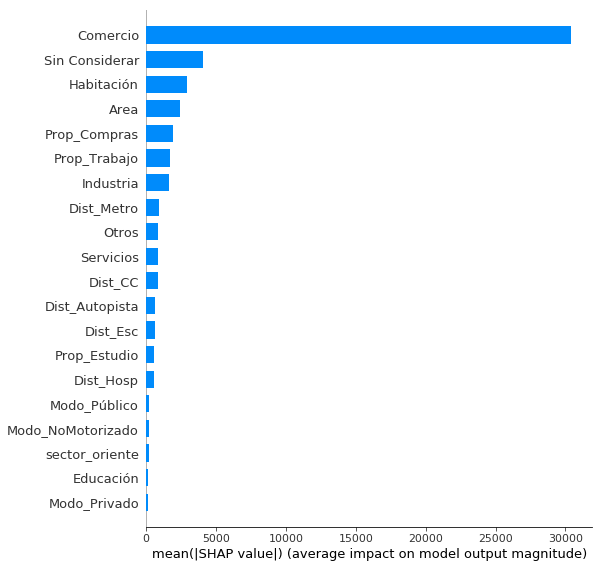

In [12]:
f = plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar')


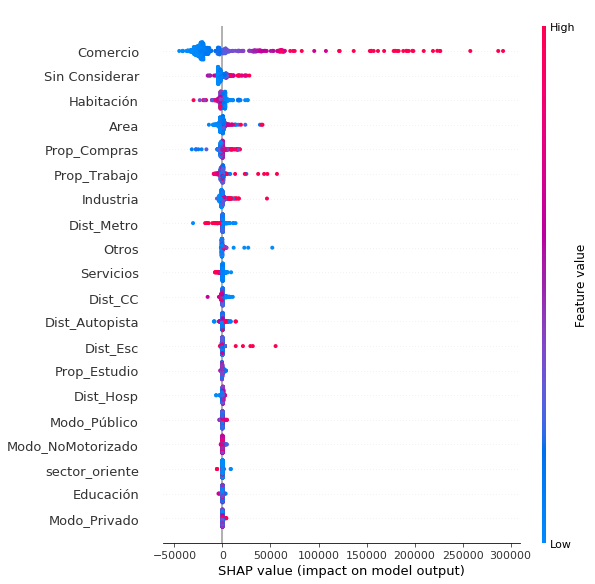

In [13]:
shap.summary_plot(shap_values, X)